In [1]:
import random
import vaex
import matplotlib
import numpy as np

%matplotlib inline

nb_inds = 10000
weight = -0.01
biais = 12031

with open("Data/datag.csv", "w") as out_file:
    out_file.write("km,price\n")
    rand_num = 0
    rand_y = 0
    for i in range(nb_inds):
        rand_num = random.randrange(1, 250000)
        rand_y = rand_num * weight + biais - (random.randrange(1, 250000 * 0.1)) + (random.randrange(1, 250000 * 0.2))
        out_file.write("{},{}\n".format(rand_num, rand_y))

In [2]:
df = vaex.open("Data/data.csv")

In [3]:
X = np.array(df[['km']]).flatten()
y = np.array(df[['price']]).flatten()
X, y

(array([240000., 139800., 150500., 185530., 176000., 114800., 166800.,
         89000., 144500.,  84000.,  82029.,  63060.,  74000.,  97500.,
         67000.,  76025.,  48235.,  93000.,  60949.,  65674.,  54000.,
         68500.,  22899.,  61789.]),
 array([3650., 3800., 4400., 4450., 5250., 5350., 5800., 5990., 5999.,
        6200., 6390., 6390., 6600., 6800., 6800., 6900., 6900., 6990.,
        7490., 7555., 7990., 7990., 7990., 8290.]))

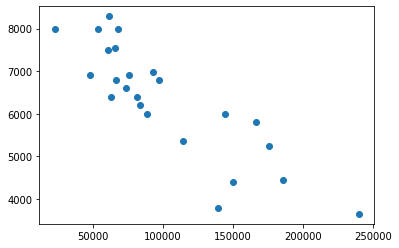

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X, y)

In [5]:
# def featureNormalize(X):
#     mean = X.mean(axis=0)
#     stdev = X.std(axis=0)
#     X = (X - mean)/stdev
#     return X, mean, stdev

def featureNormalize(X):
    minn = X.min(axis=0)
    maxx = X.max(axis=0)
    X = (X - minn)/ (maxx - minn)
    return X, minn, maxx
X, minn, maxx = featureNormalize(X)
X
# y, meany, stdevy = featureNormalize(y)

array([1.        , 0.53846366, 0.58774948, 0.74910295, 0.70520633,
       0.42330989, 0.66282974, 0.30447119, 0.56011257, 0.28144044,
       0.27236171, 0.18498763, 0.23537893, 0.34362347, 0.20313587,
       0.24470638, 0.11670144, 0.3228958 , 0.17526405, 0.19702811,
       0.1432559 , 0.21004509, 0.        , 0.17913321])

In [6]:
# with open("Data/mean_stdev.csv", "w") as mean_file:
#     mean_file.write("mean,stdev\n")
#     mean_file.write("{},{}\n".format(mean, stdev))
# X, mean, stdev

In [7]:
def predict(X, theta):
    return(np.dot(X, theta))
X = np.c_[np.ones(X.shape[0]), X]

In [8]:
def cost(X, y, theta, lbda=0.0, regularization="L2"):
    reg = 0
    if regularization == "L1":
        reg = lbda * np.sum(np.absolute(theta))
    else:
        reg = lbda * np.dot(theta, np.transpose(theta))
    return ((1/(2 * X.shape[0])) * (np.sum((predict(X, theta) - y)**2)) + reg)

In [9]:
def get_regularization(theta, lbda, size, regularization):
    if regularization == "L1":
        reg = (lbda / (2 * size)) * np.sum(np.absolute(theta[1:]))
    elif regularization == "L2":
        reg = (lbda / (2 * size)) * np.sum(np.square(theta[1:]))
    return (reg)

def get_regularization_derived(theta, lbda, size, regularization):
    if regularization == "L1":
        reg = (lbda / (2 * size)) * (theta / np.absolute(theta))
    elif regularization == "L2":
        reg = (lbda / size) * theta
    reg[0] = 0
    return (reg)    
        
def mini_batch(X, y, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0] - batch_size + 1, batch_size):
        idx_batch = indices[start_idx:start_idx + batch_size]
        yield X[idx_batch], y[idx_batch]

def exponentionnal_decay(alpha_0, epochs, decay_rate):
    return(alpha_0 * np.exp(-decay_rate * epochs))

def gradient_descent(X, y, theta, 
                     alpha=0.01,
                     num_iters=1500,
                     batch_size=-1,
                     decay_rate=0.0,
                     tol=0.0001,
                     lbda=0.001,
                     regularization="L2"):
    m = X.shape[0]
    J_history = []
    alpha_0 = alpha
    b_size = m if (batch_size <= 0 or batch_size > m) else batch_size
    decay_rate = 0.0 if b_size == m else decay_rate
    prev_cost = 0
    
    for i in range(num_iters):
        
        # regularization
        reg = get_regularization_derived(theta, lbda, b_size, regularization)

        for batch in mini_batch(X, y, b_size):
            X_tmp, y_tmp = batch
            diff = np.dot((predict(X_tmp,theta) - y_tmp), X_tmp)
            theta = theta - alpha * (diff / m + reg)
            
            # tol
            curr_cost = cost(X_tmp, y_tmp, theta, lbda=lbda, regularization=regularization)
            if abs(prev_cost - curr_cost) < tol:
                print("training finished in {} iterations".format(i))
                return theta, J_history
            prev_cost = curr_cost
            J_history.append(curr_cost)        
        
        # learning rate decay
        alpha = exponentionnal_decay(alpha_0, i, decay_rate)
        

    return theta, J_history

In [10]:
X.shape

(24, 2)

training finished in 16475 iterations
[ 8007.72672221 -4654.70918001]


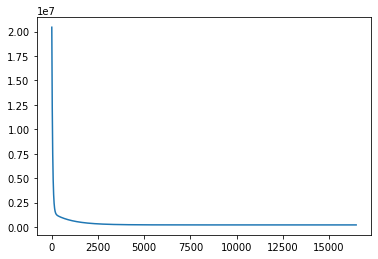

In [16]:
theta = np.zeros(2)
theta, J_history = gradient_descent(X, y, theta,
                    alpha=0.01,
                    num_iters=100000,
                    decay_rate=0.0, lbda=0.0)

print(theta)
fit = plt.figure()
ax = plt.axes()
ax.plot(J_history)
J_history[-1], theta
plt.savefig('cost_history.png') 

dd


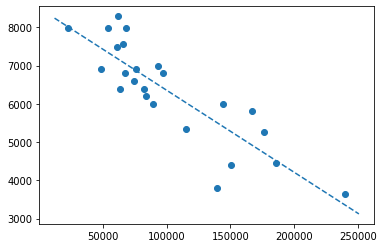

In [17]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def plot():
    X = np.array(df[['km']]).flatten()
    y = np.array(df[['price']]).flatten()
    X, minn, maxx = featureNormalize(X)
#     ys, meany, stdevy = featureNormalize(y)
    X = (X * (maxx - minn)) + minn
    theta[0] -= minn * (theta[1]) / (maxx - minn)
    theta[1] /= (maxx - minn)
    print("dd")
#     print(predict(100, theta))
    plt.scatter(X, y)
    abline(theta[1], theta[0])
    plt.savefig('visu.png')    
plot()

In [13]:
predict()

TypeError: predict() missing 2 required positional arguments: 'X' and 'theta'